# London Music Venue Search
Created by: Jakob Hegley

We have been hired by an up and coming entertainment company to help them find a suitable area of London to potentially open up a new musical venue. We have been given very little with regards to restraints, so most of our restrictions will be self imposed. In this notebook we shall work through our process of narrowing down 2 or 3 possible areas of Greater London to give to our employer. 

First we need to import all of our necessary packages:

In [1]:
# BeautifulSoup package for scrapping web pages
!pip -q install beautifulsoup4
!pip -q install lxml
from bs4 import BeautifulSoup

# Numerical package
import numpy as np

# Dataframe package
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# JSON file type package
import json

# Request package
import requests

# JSON files to Dataframe package
from pandas.io.json import json_normalize

# Basic plotting package
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# K-means machine learning package 
from sklearn.cluster import KMeans

# Time function package
import time

# Map rendering package
!pip -q install folium
import folium

Next we need to decide where in London we are searching. We shall be using the London postal code districts system to distinguish each of our areas of interest. While the Borough system does exist in London, it does not match up with the postal code system and is also not as well defined. Thankfully the postal codes are very well defined and there is a plethora of geographical data available on them. 

As our primary source on the London postal codes, we will be using the Wikipedia page on London postal districts and the pages it links to (https://en.wikipedia.org/wiki/London_postal_district). As we can clearly see there are 8 clearly defined postcode areas, and we shall be considering the districts within them as our "areas of interest."

Here is what they look like:

![Image of London Postal Districts](https://qph.fs.quoracdn.net/main-qimg-0b07cf59db9a8e881e412fd1a3d39db3)

In order to do this we will be considering each of the separate Wikipedia pages for each postal district and using the BeautifulSoup package to scrape the webpage for the HTML code that will give us our tables of information. Let's do this to one as a proof of concept. 

Let's consider the "E" postcode area (https://en.wikipedia.org/wiki/E_postcode_area) and create our DataFrame:

In [2]:
# First we define our page of interest and use the request package to pull the HTML
wikipedia_link = 'https://en.wikipedia.org/wiki/E_postcode_area'
wikipedia_page = requests.get(wikipedia_link)

# Then use the BeautifulSoup package to clean it up into a useful format
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')

# This grabs the tables in the HTML code in the class 'wikitable sortable' which is our table of interest on the webpage
table = soup.find('table', {'class':'wikitable sortable'}).tbody

# This extracts all of the rows of the table
rows = table.find_all('tr')

# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\xa0', ' ').replace('\n', '')
           for i in rows[0].find_all('th')]

# Converts columns to pd dataframe
df1 = pd.DataFrame(columns = columns)
df1

,Postcode district,Post town,Coverage,Local authority area(s)


Now we have an empty DataFrame with our necessary columns defined from the webpage. Now let's populate it with the data from the table, making sure to change any syntax along the way:

In [3]:
# Here we grab the actual values for rows from the HTML code and append it to our empty DataFrame 
for i in range(1, len(rows)):
    ths = rows[i].find_all('th')
    tds = rows[i].find_all('td')    
    values = [th.text.replace('\n', '') for th in ths] + [td.text.replace('\n', '') for td in tds]
        
    df1 = df1.append(pd.Series(values, index = columns), ignore_index = True)
    df1

# Now let's have a look
df1.head()

,Postcode district,Post town,Coverage,Local authority area(s)
0,E1,LONDON,"Eastern head district: Aldgate (part), Bishops...","Tower Hamlets, Hackney, City of London"
1,E1W,LONDON,"Wapping, St Katharine Docks, Stepney (part), S...",Tower Hamlets
2,E2,LONDON,"Bethnal Green district: Bethnal Green, Haggers...","Tower Hamlets, Hackney"
3,E3,LONDON,"Bow district: Bow, Bow Common, Bromley-by-Bow,...","Tower Hamlets, Newham"
4,E4,LONDON,"Chingford district: Chingford, Sewardstone, Hi...","Waltham Forest, Enfield, Epping Forest (Essex)"


The "Coverage" column in the case is a list of subdistricts, and the "Local authority area(s)" refers to which London Boroughs are found within each postcode. 

Now that we have shown this in concept, let's apply this to the other 7 postcode areas all at once using a loop:

In [4]:
# Here we make list of the remaining postcodes
postcode_list = ['EC', 'N', 'NW', 'SE', 'SW', 'W', 'WC']

# This loop does everything we did for the "E" postcode area for the other areas and the appends the results to the DataFrame we already made
for i in postcode_list: 
    wikipedia_link = 'https://en.wikipedia.org/wiki/{}_postcode_area'.format(i)
    wikipedia_page = requests.get(wikipedia_link)
    soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
    table = soup.find('table', {'class':'wikitable sortable'}).tbody
    rows = table.find_all('tr')
    df2 = pd.DataFrame(columns = columns)
    
    for k in range(1, len(rows)):
        ths = rows[k].find_all('th')
        tds = rows[k].find_all('td')    
        values = [th.text.replace('\n', '') for th in ths] + [td.text.replace('\n', '') for td in tds]        
        df2 = df2.append(pd.Series(values, index = columns), ignore_index = True)    

    df1 = df1.append(df2)

Now let's have a look a the result and the size of our result:

In [5]:
print(df1.shape)
df1.head()

(184, 4)


,Postcode district,Post town,Coverage,Local authority area(s)
0,E1,LONDON,"Eastern head district: Aldgate (part), Bishops...","Tower Hamlets, Hackney, City of London"
1,E1W,LONDON,"Wapping, St Katharine Docks, Stepney (part), S...",Tower Hamlets
2,E2,LONDON,"Bethnal Green district: Bethnal Green, Haggers...","Tower Hamlets, Hackney"
3,E3,LONDON,"Bow district: Bow, Bow Common, Bromley-by-Bow,...","Tower Hamlets, Newham"
4,E4,LONDON,"Chingford district: Chingford, Sewardstone, Hi...","Waltham Forest, Enfield, Epping Forest (Essex)"


In [6]:
df1.tail()

,Postcode district,Post town,Coverage,Local authority area(s)
9,WC2B,LONDON,"Drury Lane, Kingsway, Aldwych","Camden, Westminster"
10,WC2E,LONDON,Covent Garden,Westminster
11,WC2H,LONDON,"Leicester Square, St. Giles","Camden, Westminster"
12,WC2N,LONDON,Charing Cross,Westminster
13,WC2R,LONDON,"Somerset House, Temple (west)",Westminster


We need to reset the index and rename some of the columns. We also really only need the "Postcode district" and "Local authority area(s)" columns, so we create a new DataFrame with just that data:

In [7]:
df1.reset_index(drop=True)
df1.rename(columns = {'Local authority area(s)':'Borough(s)'}, inplace = True)
df1.rename(columns = {'Postcode district':'Postcode'}, inplace = True)
df_data = df1[['Postcode', 'Borough(s)']]
df_data.head()

,Postcode,Borough(s)
0,E1,"Tower Hamlets, Hackney, City of London"
1,E1W,Tower Hamlets
2,E2,"Tower Hamlets, Hackney"
3,E3,"Tower Hamlets, Newham"
4,E4,"Waltham Forest, Enfield, Epping Forest (Essex)"


Some of these postcodes actually do not designate geographical areas on a map, they represent singular addresses of high postal volume (PO boxes essentially). These have the phrase "non-geographic" in their Boroughs column, thus we shall remove these:

In [8]:
df_data = df_data[df_data['Borough(s)'] != 'non-geographic'].reset_index(drop=True)
print(df_data.shape)

(173, 2)


Now that we have our postcodes, we need their general Latitude and Longitude coordinates. The geocoder package can be useful for this, but I found that it took too long to run and its results were not consistant. Thankfully I found a dataset that lists the Lat,Long for each of our London postcodes at https://www.freemaptools.com/download-uk-postcode-lat-lng.htm. The necessary .csv file (postcode-oucodes.csv) can be found on my GitHub (https://github.com/JakobHegley) under the Data-Science-Capstone repository along with all of the other datasets I imported into this notebook. 

In [9]:
df_latlong = pd.read_csv('postcode-outcodes.csv')
df_latlong.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


Notice that this data set contains the locations for many postcodes unrelated to our search (postcodes that are in the overall Greater London area, but do not have the Post town of "LONDON"). We shall create a new DataFrame of just the relevant data:

In [10]:
df_latlong_data = df_latlong[df_latlong['postcode'].isin(df_data['Postcode'])]
print(df_latlong_data.shape)
df_latlong_data.head()

(173, 4)


,id,postcode,latitude,longitude
728,730,E1,51.51766,-0.05841
729,731,E10,51.56814,-0.01153
730,732,E11,51.56769,0.01443
731,733,E12,51.54992,0.05404
732,734,E13,51.52700,0.02705


Next let's do some clean up by renaming our columns to match those from our primary dataset and reset the index:

In [11]:
df_latlong_data.rename(columns = {'postcode':'Postcode'}, inplace = True)
df_latlong_data.rename(columns = {'latitude':'Latitude'}, inplace = True)
df_latlong_data.rename(columns = {'longitude':'Longitude'}, inplace = True)
df_latlong_data_clean = df_latlong_data[['Postcode', 'Latitude', 'Longitude']].reset_index(drop=True)
df_latlong_data_clean.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Postcode,Latitude,Longitude
0,E1,51.51766,-0.05841
1,E10,51.56814,-0.01153
2,E11,51.56769,0.01443
3,E12,51.54992,0.05404
4,E13,51.52700,0.02705


Now we want to make sure that our datasets match by index, so we shall sort our original dataset along the Postcode column, putting them in alphanumeric order:

In [12]:
df_data.sort_values(by=['Postcode'], inplace=True)
df_data.reset_index(drop=True).head()

,Postcode,Borough(s)
0,E1,"Tower Hamlets, Hackney, City of London"
1,E10,"Waltham Forest, Hackney"
2,E11,"Waltham Forest, Redbridge"
3,E12,"Newham, Redbridge"
4,E13,Newham


Then we shall do the same to the Lat,Long dataset:

In [13]:
df_latlong_data_clean.sort_values(by=['Postcode'], inplace=True)
df_latlong_data_clean.reset_index(drop=True).head()

,Postcode,Latitude,Longitude
0,E1,51.51766,-0.05841
1,E10,51.56814,-0.01153
2,E11,51.56769,0.01443
3,E12,51.54992,0.05404
4,E13,51.52700,0.02705


Now we can join these two datasets using the Postcode column as a common axis:

In [14]:
df_data2 = df_data.join(df_latlong_data_clean.set_index('Postcode'), on='Postcode')
df_data2.reset_index(drop=True,inplace=True)
df_data2.head()

,Postcode,Borough(s),Latitude,Longitude
0,E1,"Tower Hamlets, Hackney, City of London",51.51766,-0.05841
1,E10,"Waltham Forest, Hackney",51.56814,-0.01153
2,E11,"Waltham Forest, Redbridge",51.56769,0.01443
3,E12,"Newham, Redbridge",51.54992,0.05404
4,E13,Newham,51.52700,0.02705


Thanks to some "future sight" we notice that some of the datapoints are still non-geographic in nature or even represent fictional postcodes (used in television for example). We shall remove these:

In [15]:
df_data2.drop([12, 18, 21, 56], inplace = True)
df_data2.reset_index(drop=True,inplace=True)

Now we can see the final size of our list of postcodes:

In [16]:
df_data2.shape

(169, 4)

Another sort of data that may be helpful will be area in square meters, population, and population density of each postcode. I created a .csv file (Areas-and-Population.csv) of this data using data that I collected by hand from these sources, https://www.streetlist.co.uk/ and https://www.streetcheck.co.uk/postcode/alldistricts. Let's load that in:

In [17]:
df_area_pop = pd.read_csv('Areas-and-Population.csv')
df_area_pop.head()

,Postcode,Area (km2),Population,Population Density (Person per km2)
0,E1,4.30,86974,20226.51
1,E10,5.05,48490,9601.98
2,E11,8.78,61735,7031.32
3,E12,5.13,43771,8532.36
4,E13,3.45,51677,14978.84


Let's double check that it has the same amount of rows as our primary dataset:

In [18]:
df_area_pop.shape

(169, 4)

Now let's join this data with our primary dataset to create the final data set we will use to describe our postcode areas:

In [19]:
df_final = df_data2.join(df_area_pop.set_index('Postcode'), on='Postcode')
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,Postcode,Borough(s),Latitude,Longitude,Area (km2),Population,Population Density (Person per km2)
0,E1,"Tower Hamlets, Hackney, City of London",51.51766,-0.05841,4.30,86974,20226.51
1,E10,"Waltham Forest, Hackney",51.56814,-0.01153,5.05,48490,9601.98
2,E11,"Waltham Forest, Redbridge",51.56769,0.01443,8.78,61735,7031.32
3,E12,"Newham, Redbridge",51.54992,0.05404,5.13,43771,8532.36
4,E13,Newham,51.52700,0.02705,3.45,51677,14978.84


Now let's get a visualization of these postcodes. We shall use the folium map rendering package to create a map with circles reresenting the general area of each postcode. For the calculations of the radius for each circle, I considered each postcode to be of square shape and considered a circle being inscribed within said square. The ratio between these two shape is $\frac{\pi}{4} \approx 0.785$. Thus I am considering the radius that will give my circle approximetly 78.5% of the area of my original district. I also added pop-ups that when clicked on give the name of the postcode and its associated Boroughs. 

In [20]:
map_london = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

for lat, lng, borough, postcode, area in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough(s)'], df_final['Postcode'], df_final['Area (km2)']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=np.sqrt((np.pi/4)*area/np.pi)*1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

While there is certainly some overlap found between some postcodes, this may actually help us later in defining the venue characteristics of each postcode as well as nearby postcodes. 

Now we shall utilize the FourSquare API to gather nearby venue data for each of our postcodes. In the end we wish to find a location were there are no nearby music venues (or anything else akin to a music venue such as a concert hall) already in place. We shall also consider areas that already have a flourishing local food/entertainment scene where a music venue will fit right in.

First we need our credentials:

In [21]:
CLIENT_ID = '2M215C02NXH4FNC1XQ00OC135ZV1GWYJWCA1P2S3A4DZZ1IJ'
CLIENT_SECRET = 'I4SQNCDYTEQBJ0L4YS23NO0SAU5OYLHC211D5025GLUUPOHP' 
VERSION = '20180605' 

Here we define a function that shall make our API calls to FourSquare, gather the data, and place it into a DataFrame. A point of interest is how I redefine the radius for each individual call. I utilize the same calculations done in the map above. This way we are making sure to search as much of each postcode as possible. This is essential due to the differing sizes of these postcodes. Too small of a radius and we are missing out on may venues in the larger postcodes. Too large a radius and we will have duplicates of many venues in our smaller postcodes. Changing these radii on the fly allows us to reach a nice middle ground.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, area, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng, area in zip(names, latitudes, longitudes, area):
        
        # Defining our radius of interest
        radius = np.sqrt((np.pi/4)*area/np.pi)*1000
            
        # Create API URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return nearby venue information
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Creating a new DataFrame to store our venue data
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can apply this function to our final dataset (if you receive an error message just re-run the cell). Quick warning, depending on the time in which you are running this cell, you may get more venues than I did while making this. This may effect how your K-means results might be, especially how many clusters are created. Please keep that in mind:

In [24]:
london_venues = getNearbyVenues(names=df_final['Postcode'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude'],
                                   area = df_final['Area (km2)']
                                  )

Let's have a look at our results:

In [25]:
print(london_venues.shape)
london_venues.head()

(9636, 7)


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,E1,51.51766,-0.05841,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop
1,E1,51.51766,-0.05841,Rinkoff's Bakery,51.519964,-0.053238,Bakery
2,E1,51.51766,-0.05841,Tayyabs,51.517240,-0.063476,North Indian Restaurant
3,E1,51.51766,-0.05841,Lahore One,51.514725,-0.059399,Indian Restaurant
4,E1,51.51766,-0.05841,One Mile End,51.520151,-0.056136,Brewery


Let's see how many venues we found for each postcode:

In [26]:
london_venues.groupby('Postcode').count()['Venue']

Postcode
E1      100
E10      45
E11      71
E12      15
E13      20
E14     100
E15     100
E16      87
E17     100
E18      30
E1W      28
E2      100
E3       86
E4       45
E5       72
E6       54
E7       28
E8      100
E9      100
EC1A     17
EC1M     16
EC1N     35
EC1R     65
EC1V     89
EC1Y     47
EC2A     18
EC2M     45
EC2N      7
EC2R     11
EC2V     19
EC2Y     36
EC3A     19
EC3M     15
EC3N     46
EC3R     26
EC3V     18
EC4A     34
EC4M     42
EC4N     15
EC4R     24
EC4V     40
EC4Y     44
N1      100
N10      71
N11      25
N12      55
N13      37
N14      41
N15      46
N16      93
N17      79
N18      45
N19      58
N2       46
N20      48
N21      25
N22      79
N3       46
N4      100
N5       42
N6       72
N7      100
N8       70
N9       35
NW1     100
NW10     81
NW11     59
NW2      77
NW3     100
NW4      64
NW5     100
NW6     100
NW7      25
NW8      68
NW9      53
SE1     100
SE10    100
SE11     44
SE12     18
SE13     87
SE14     54
SE15    100
SE16   

Now let's consider how many unique venue types we have:

In [27]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 398 uniques categories.


Let's have a detailed look of all of these. This may seem like alot to look through, but we need to get an idea of what sort of "Music Venues" were found:

In [28]:
london_venues['Venue Category'].unique()

array(['Coffee Shop', 'Bakery', 'North Indian Restaurant',
       'Indian Restaurant', 'Brewery', 'Hotel', 'Kebab Restaurant',
       'Movie Theater', 'Pub', 'Farm', 'Middle Eastern Restaurant',
       'Bookstore', 'Art Gallery', 'Café', 'Restaurant',
       'French Restaurant', 'Yoga Studio', 'Chocolate Shop',
       'Cosmetics Shop', 'Music Venue', 'Ice Cream Shop',
       'Italian Restaurant', 'Burger Joint', 'Beer Bar', 'Market',
       'Gym / Fitness Center', 'Park', 'Pilates Studio', 'Flea Market',
       'Korean Restaurant', 'Garden', 'Pizza Place', 'Creperie',
       'Recreation Center', 'Szechuan Restaurant',
       'Vegetarian / Vegan Restaurant', 'Japanese Restaurant',
       'Chinese Restaurant', 'Arts & Crafts Store', 'Bar', 'Event Space',
       'Camera Store', 'BBQ Joint', 'Food Court', 'Turkish Restaurant',
       'Sandwich Place', 'Falafel Restaurant', 'Thrift / Vintage Store',
       'Asian Restaurant', 'Gastropub', 'Dive Bar', 'Dessert Shop',
       'Fried Chicken Jo

After searching through this list, we can create a list of musical performance based venue types and then create a new DataFrame of just those venues:

In [29]:
musiclist = ['Music Venue', 'Concert Hall', 'Opera House', 'Jazz Club', 'Piano Bar', 'Performing Arts Venue']
london_music = london_venues[london_venues['Venue Category'].isin(musiclist)]
london_music

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
26,E1,51.51766,-0.05841,Wilton's Music Hall,51.510409,-0.066865,Music Venue
147,E11,51.56769,0.01443,Luna The Home Of Live music,51.568319,0.010347,Music Venue
575,E17,51.58623,-0.01796,Walthamstow Assembly Hall,51.590816,-0.012425,Concert Hall
663,E18,51.59176,0.02705,Redbridge Drama Centre,51.598705,0.022621,Performing Arts Venue
760,E2,51.52939,-0.06080,Oval Space,51.533238,-0.059398,Music Venue
845,E3,51.52789,-0.02482,Autumn Street Studio,51.535294,-0.020090,Music Venue
1164,E8,51.54202,-0.06315,The Blue Studios,51.547785,-0.066053,Music Venue
1388,EC1R,51.52475,-0.10713,Piano Works,51.523025,-0.107836,Music Venue
1415,EC1V,51.52549,-0.09701,LSO St Luke's,51.524965,-0.093814,Concert Hall
1517,EC1Y,51.52272,-0.09280,LSO St Luke's,51.524965,-0.093814,Concert Hall


Now let's map out these venues along side our circular district radii. But to make it clear which type is which, I have color coated them as such:
- <font color=red>Red</font> = Music Venue
- <font color=blue>Blue</font> = Concert Hall
- <font color=green>Green</font> = Opera House
- <font color=purple>Purple</font> = Jazz Club
- <font color=orange>Orange</font> = Piano Bar
- <font color=yellow>Yellow</font> = Performing Arts Hall

Note that I still have the pop-ups that tell you the postcode and the venue type.

In [30]:
colorlist = ['red', 'blue', 'green', 'purple', 'orange', 'yellow']
map_london_music = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

for lat, lng, borough, postcode, area in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough(s)'], df_final['Postcode'], df_final['Area (km2)']):
    label = '{}, {}'.format(postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=np.sqrt((np.pi/4)*area/np.pi)*1000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_music) 

for lat, lng, postcode, category in zip(london_music['Venue Latitude'], london_music['Venue Longitude'], london_music['Postcode'], london_music['Venue Category']):
    label = '{}, {}'.format(postcode, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colorlist[musiclist.index(category)],
        fill=True,
        fill_color=colorlist[musiclist.index(category)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_music)  
    

    
map_london_music

Right away we can see some potentially good areas of interest. It seems that the Northwestern area (NW) is almost completely missing any musical performance venues entirely. While the Southeastern (SE) section has some sorts of performance venues, they are only concert halls, a jazz club, and a performing arts hall. A more general music venue would probably fit very well in there. Another area of interest is the most eastern edge of the West (W) postcode. We do see some Jazz clubs and a Concert Hall here but nothing more general. While there are some music venues nearby, they are still a decent enough distance away to leave an interesting gap worth exploiting. These three locations will most likely be our areas of choice. However, we still need to narrow down a specific postcode within each distric area. 

We shall do this by apply K-means clustering to find ways of grouping the postcodes into venue based clusters that describe their characteristics. 

In order to do K-means clustering, we need a numerical measure to run it against. We shall do this by creating a DataFrame of the venue category frequency in each postcode. To do this we will first make a new DataFrame with binary options of whether each venue category is in each postcode.

In [31]:
# One hot encoding that will create columns for each venue category. Then for each potcode it will add a 1 in the column if that category is in that postcode, and a 0 if not
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# Adds Postcode column back to DataFrame
london_onehot['Postcode'] = london_venues['Postcode'] 

# Moves the Postcode column to the first column spot
cols = london_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Postcode')))
london_onehot = london_onehot.reindex(columns= cols)

london_onehot.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Football Field,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,P

The amount of rows in this should match that of the london_venues DataFrame, let's double check:

In [32]:
london_onehot.shape

(9636, 399)

Next we group by Postcode and apply the mean pandas method to create rows for each postcode with venue frequency percentages: 

In [33]:
london_grouped = london_onehot.groupby('Postcode').mean().reset_index()
london_grouped.head()

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Football Field,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,P

Again let's make sure we have all of our postcodes:

In [34]:
london_grouped.shape

(169, 399)

This next bit of code will show you a nice look at the top 10 venues for each postcode, but due to it showng it for all postcodes, thus cluttering the notebook, I will leave it commented.

In [ ]:
#num_top_venues = 10

#for code in london_grouped['Postcode']:
#    print("----"+code+"----")
#    temp = london_grouped[london_grouped['Postcode'] == code].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

But how about if we create a DataFrame that shows the top 5 or so venues in each postcode. First we make a function:

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then we apply it. Notice that you can change the number of top venues variable to get deeper information about each postcode. The top 5 should be fine to get an idea of how they will be clustered. 

In [36]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# Creates columns according to number of top venues and applies the proper numerical suffix
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Creates a new DataFrame
postcode_venues_sorted = pd.DataFrame(columns=columns)
postcode_venues_sorted['Postcode'] = london_grouped['Postcode']

for ind in np.arange(london_grouped.shape[0]):
    postcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

postcode_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,E1,Coffee Shop,Pub,Hotel,Café,Indian Restaurant
1,E10,Pub,Grocery Store,Café,Park,Chinese Restaurant
2,E11,Pub,Grocery Store,Park,Café,Restaurant
3,E12,Indian Restaurant,Train Station,Restaurant,Gym / Fitness Center,Park
4,E13,Pub,Café,Gym / Fitness Center,Convenience Store,Grocery Store


As we stated before, in order to use K-means clustering, we need purely numerical data, thus we create a new DataFrame from the london_grouped data but we drop the postcode column.

In [37]:
london_grouped_clustering = london_grouped.drop('Postcode', 1)
london_grouped_clustering.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Football Field,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,

Before we actually apply the K-means clustering algorithm, we need to decide on its one and only parameter, the k-value. Recall that the k-value refers to how many clusters it will batch the data into. Finding the best k-value is a subject all to itself, but thankfully there are several methods that have been devised to find the most "helpful" value. In my case I chose to use the "elbow-point" method which involves calculating the K-mans algorithm for multiple values of k, then considering the overall average of the average distance of each point to its designated cluster center. You then graph these distances for each k-value. This graph should be decreasing consistently, but we are looking for the first moment when the decreasing rate from k-value to k-value slows down sharply. I created a function below that takes in a starting and ending k-value as well as a DataFrame, then produces a graph of these average distances for each k-value:

In [38]:
def KmeanDetermineBestK(start, end, Data_Frame):
    mean_each_k = []
    
    for i in range(start, end+1):
        kclusters = i 
        kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Data_Frame)
        Data_Frame_copy = Data_Frame.copy()
        Data_Frame_copy['Cluster Labels'] = kmeans.labels_.tolist()
        distance_list = []
        for j in range(0, Data_Frame_copy.shape[0]):
            difference_sq = [(k-m)**2 for k, m in zip(Data_Frame_copy.iloc[j].tolist(), kmeans.cluster_centers_[Data_Frame_copy.at[j, 'Cluster Labels']].tolist())]
            distance = np.sqrt(sum(difference_sq))
            distance_list.append(distance)
        mean_each_k.append(np.array(distance_list).mean())
        
    plt.plot([item for item in range(start, end+1)], mean_each_k, marker = 'o')
    plt.title('K Value vs Mean Distance from Centroids')
    plt.xlabel('K Value')
    plt.ylabel('Mean Distance from Centriods')
    plt.grid(True)
    plt.show() 

Let's apply this to our dataset for k-values from 2 to 10:

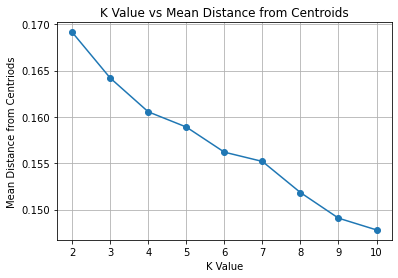

In [39]:
KmeanDetermineBestK(2,10, london_grouped_clustering)

Themost drastic slow down that occurs after k=4, so we will choose this value for our actual analysis. 

In [40]:
kclusters = 4

london_grouped_clustering = london_grouped.drop('Postcode', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

Now that we have our clusters, let's add the cluster numbers to each postcode in the postcode_venues_sorted DataFrame and then join this to a copy of our df_final DataFrame:

In [41]:
postcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = df_final

london_merged = london_merged.join(postcode_venues_sorted.set_index('Postcode'), on='Postcode')

london_merged.head()

,Postcode,Borough(s),Latitude,Longitude,Area (km2),Population,Population Density (Person per km2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,E1,"Tower Hamlets, Hackney, City of London",51.51766,-0.05841,4.30,86974,20226.51,1,Coffee Shop,Pub,Hotel,Café,Indian Restaurant
1,E10,"Waltham Forest, Hackney",51.56814,-0.01153,5.05,48490,9601.98,3,Pub,Grocery Store,Café,Park,Chinese Restaurant
2,E11,"Waltham Forest, Redbridge",51.56769,0.01443,8.78,61735,7031.32,3,Pub,Grocery Store,Park,Café,Restaurant
3,E12,"Newham, Redbridge",51.54992,0.05404,5.13,43771,8532.36,1,Indian Restaurant,Train Station,Restaurant,Gym / Fitness Center,Park
4,E13,Newham,51.52700,0.02705,3.45,51677,14978.84,3,Pub,Café,Gym / Fitness Center,Convenience Store,Grocery Store


Let's map out each postcode and color code them by which cluster the belong to:

In [42]:
map_clusters = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Postcode'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can definitely see some patterns here. Clusters 0 (red), 1 (purple), and 4 (orange) seem to be almost entirely focused around central London. Clusters 2 (blue) seems to be pretty evenly spread, whereas cluster 3 (green) seems to make up the outer edges of the area.

Let's look at each cluster and take note of their most common venues, which postcodes they contain, and their population densities to gain some insights on what the clusters may represent:

### Cluster 0 (Red):

In [43]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Postcode,Population Density (Person per km2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,E18,6814.19,0,Italian Restaurant,Grocery Store,Coffee Shop,Bar,Supermarket
10,E1W,15889.09,0,Coffee Shop,Park,Italian Restaurant,Pub,Pizza Place
15,E6,8483.64,0,Hotel,Supermarket,Coffee Shop,Pub,Grocery Store
16,E7,15765.08,0,Grocery Store,Café,Hotel,Pub,Indian Restaurant
44,N11,7252.74,0,Grocery Store,Hardware Store,Electronics Store,Sporting Goods Shop,Café
45,N12,5971.68,0,Coffee Shop,Grocery Store,Supermarket,Café,Fast Food Restaurant
46,N13,8451.04,0,Grocery Store,Greek Restaurant,Park,Pub,Italian Restaurant
47,N14,5047.63,0,Pub,Grocery Store,Park,Gym / Fitness Center,Café
48,N15,14305.82,0,Café,Grocery Store,Coffee Shop,Bus Stop,Pizza Place
51,N18,6856.95,0,Pub,Turkish Restaurant,Grocery Store,Supermarket,Coffee Shop


With the abundance of Grocery stores and Coffee shops being the most common, I would suspect that these represent residential areas. Still plenty of Pubs and simple restaurants as well, but not a huge variety. Notice how these areas actually have some the most average spread of population densities, showing that it is more uniform. These would most likely not make good places for a music venue due to it not being supported by the buinesses already in place. Notice how the Northwest (NW) area is almost entirely found in this cluster, which would explain its lack of musical performance venues. 

### Cluster 1 (Purple):

In [44]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Postcode,Population Density (Person per km2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,E1,20226.51,1,Coffee Shop,Pub,Hotel,Café,Indian Restaurant
3,E12,8532.36,1,Indian Restaurant,Train Station,Restaurant,Gym / Fitness Center,Park
5,E14,12126.99,1,Italian Restaurant,Hotel,Coffee Shop,Park,Indian Restaurant
19,EC1A,11559.26,1,Pub,French Restaurant,Wine Bar,Coffee Shop,Italian Restaurant
21,EC1N,24377.78,1,Coffee Shop,Sandwich Place,Pub,Food Truck,Gym / Fitness Center
23,EC1V,22143.68,1,Coffee Shop,Food Truck,Pub,Italian Restaurant,Café
24,EC1Y,25431.03,1,Food Truck,Coffee Shop,Pub,Hotel,Gym / Fitness Center
25,EC2A,8827.27,1,Gym / Fitness Center,Italian Restaurant,Food Truck,Coffee Shop,English Restaurant
26,EC2M,7393.10,1,Sandwich Place,Coffee Shop,Gym / Fitness Center,Boxing Gym,Café
28,EC2R,9318.18,1,French Restaurant,Wine Bar,Coffee Shop,Modern European Restaurant,Sushi Restaurant


This definitely seems to represent the highly economically prosperous downtown areas of central London. Tons of high quality restaurants, simple food shops, and coffee shops mixed together, as well as a large variety of entertainment and shopping options. While these areas would be great to make a new music venue, as we already saw, these areas already have a plethora of musical performance venues, so it would be difficult to make something new prosperous. 

### Cluster 2 (Blue):

In [45]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Postcode,Population Density (Person per km2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,E16,6054.73,2,Hotel,Grocery Store,Coffee Shop,Café,Pub
20,EC1M,22290.91,2,Beer Bar,Hotel,Italian Restaurant,Plaza,Spanish Restaurant
27,EC2N,4711.11,2,Café,Event Space,Hotel,Boxing Gym,German Restaurant
33,EC3N,5814.29,2,Hotel,Sandwich Place,Cocktail Bar,Coffee Shop,Salad Place
113,SW1A,2831.09,2,Outdoor Sculpture,Pub,Plaza,Hotel,Monument / Landmark
115,SW1H,22129.41,2,Coffee Shop,Hotel,Hotel Bar,Juice Bar,Café
116,SW1P,17479.78,2,Hotel,Coffee Shop,Café,Italian Restaurant,Restaurant
117,SW1V,25081.48,2,Hotel,Pub,Pizza Place,Turkish Restaurant,Park
118,SW1W,13237.04,2,Hotel,Italian Restaurant,Pub,Bakery,Coffee Shop
119,SW1X,13427.50,2,Hotel,Café,Pub,Plaza,Italian Restaurant


This cluster is dominated by hotels. Still plenty of restaurants to be seen, but we can see that these are huge tourist areas. The one outlier to the east can be explained by noticing its vicinity to an airport. Certainly these could be areas of interest, but we need to consider music venues already in place.

### Cluster 3 (Yellow):

In [46]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(6, london_merged.shape[1]))]]

,Postcode,Population Density (Person per km2),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,E10,9601.98,3,Pub,Grocery Store,Café,Park,Chinese Restaurant
2,E11,7031.32,3,Pub,Grocery Store,Park,Café,Restaurant
4,E13,14978.84,3,Pub,Café,Gym / Fitness Center,Convenience Store,Grocery Store
6,E15,8026.76,3,Pub,Grocery Store,Park,Hotel,Café
8,E17,7783.74,3,Pub,Grocery Store,Coffee Shop,Café,Pizza Place
11,E2,18578.21,3,Coffee Shop,Pub,Café,Wine Bar,Cocktail Bar
12,E3,11816.18,3,Pub,Coffee Shop,Café,Pizza Place,Grocery Store
13,E4,3436.87,3,Pub,Grocery Store,Coffee Shop,Park,Italian Restaurant
14,E5,11985.40,3,Pub,Café,Park,Coffee Shop,Grocery Store
17,E8,17146.57,3,Pub,Café,Coffee Shop,Cocktail Bar,Bakery


This cluster is nothing but Pubs, Coffee shops, and simple restaurants as well as some parks and recreational spaces. This most likely just describes generally high populace areas where people go for simple food. These can be great areas of interest because of the high foot traffic they most likely get. 

## Conclusions:

With all of this anlysis done we can narrow down our options to these several choices, in order of likelyhood of success:

- **W1** (in particular W1K, W1J, W1S): This is our best choice. Relatively high population densities, with plenty of surrounding general venues to keep foot traffic flowing to spread interest. While there may be some nearby Jazz Clubs and a Concert Hall, this is a solid lack of a general music venue for quite a distance. Since most of this postcode area works, there is likely many real estate options as well. 

- **SE3**: This ones biggest strength is its distance from any musical venues while still falling into cluster 3, which means that the nearby food options could be an advantage. The surrounding areas are also highly residential, so the music venue would cater to a large amount of people. 

- **NW** (the northwest portion in particular): This is one that has one major flaw and one major strength. The strength is the utter lack of any music venues of any type whatsoever, making the desire for one probably rather high. Its biggest flaw is that it is almost entirely residential, so the music venue would have to create its buzz and support itself all on its own. 